# Unit weighted regression accuracy

## Comparing simulation results

In this first section we will plot the error rate of unit-weighted regression in order to verify we match [Stucchio's simulation](https://www.chrisstucchio.com/blog/2014/equal_weights.html).

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt

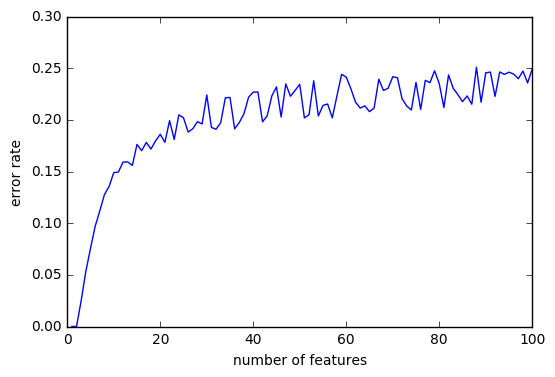

In [2]:
TRIALS = 10000
MAX_N = 100
stats = []
for n in xrange(1, MAX_N+1):
    errors = 0
    u = np.full(shape=n, fill_value=1.0/n)
    for _ in xrange(TRIALS):
        h = np.random.dirichlet(alpha=np.ones(n))
        x = np.random.randint(low=0, high=1+1, size=n)
        y = np.random.randint(low=0, high=1+1, size=n)
        if np.sign(np.dot(h, (x - y))) * np.sign(np.dot(u, (x - y))) < 0:
            errors += 1
    stats.append((n, float(errors) / TRIALS))
num_features, error_rate = zip(*stats)
plt.plot(num_features, error_rate)
plt.xlabel('number of features')
plt.ylabel('error rate')

Notice that if we plot all the errors, including those were a classifier doesn't give a prediction, the results are markedly different for small dimensions, though they converge for a higher number of features:

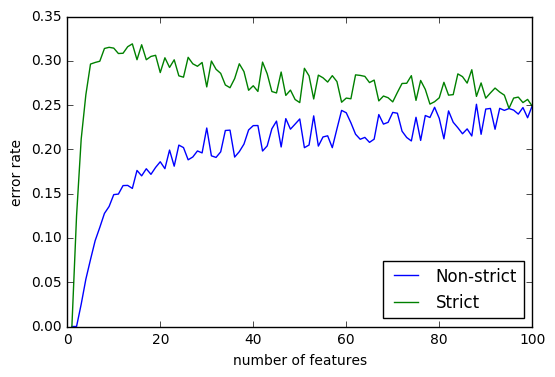

In [3]:
TRIALS = 10000
MAX_N = 100
stats = []
for n in xrange(1, MAX_N+1):
    errors = 0
    u = np.full(shape=n, fill_value=1.0/n)
    for _ in xrange(TRIALS):
        h = np.random.dirichlet(alpha=np.ones(n))
        x = np.random.randint(low=0, high=1+1, size=n)
        y = np.random.randint(low=0, high=1+1, size=n)
        if np.sign(np.dot(h, (x - y))) != np.sign(np.dot(u, (x - y))):
            errors += 1
    stats.append((n, float(errors) / TRIALS))
num_features, error_rate_strict = zip(*stats)
plt.plot(num_features, error_rate, label='Non-strict')
plt.plot(num_features, error_rate_strict, label='Strict')
plt.xlabel('number of features')
plt.ylabel('error rate')
plt.legend(loc='lower right')

## A faster simulation

We start by creating more efficient, vectorized code for doing simulations:

In [4]:
def compute_error_fraction_naive(n, samples=10000, strict_error=False):
    errors = 0
    u = np.full(shape=n, fill_value=1.0/n)
    for _ in xrange(samples):
        h = np.random.dirichlet(alpha=np.ones(n))
        x = np.random.randint(low=0, high=1+1, size=n)
        y = np.random.randint(low=0, high=1+1, size=n)
        if strict_error:
            if np.sign(np.dot(h, (x - y))) != np.sign(np.dot(u, (x - y))):
                errors += 1
        else:
            if np.sign(np.dot(h, (x - y))) * np.sign(np.dot(u, (x - y))) < 0:
                errors += 1
    return float(errors) / samples

def compute_error_fraction(n, samples=10000, strict_error=False):
    u = np.full(shape=n, fill_value=1.0) # normalized separately for rounding issues
    hv = np.random.dirichlet(alpha=np.ones(n), size=samples)
    xv = np.random.randint(low=0, high=1+1, size=(samples, n))
    yv = np.random.randint(low=0, high=1+1, size=(samples, n))
    row_dot = lambda a, b: np.einsum('ij,ij->i', a, b)
    if strict_error:
        diff = np.equal(np.sign(row_dot(hv, (xv - yv))), np.sign(np.dot(u, (xv - yv).T) / n))
    else:
        diff = np.sign(row_dot(hv, (xv - yv))) * np.sign(np.dot(u, (xv - yv).T) / n) >= 0
    return 1.0 - float(np.count_nonzero(diff)) / samples

print 'Strict error:',\
      compute_error_fraction_naive(3, strict_error=True),\
      compute_error_fraction(3, strict_error=True)
print 'Non strict error:',\
      compute_error_fraction_naive(3, strict_error=False),\
      compute_error_fraction(3, strict_error=False)
        
from timeit import timeit
print 'Time with naive version:', timeit(lambda: compute_error_fraction_naive(3, strict_error=True), number=10)
print 'Time with vectorized version:', timeit(lambda: compute_error_fraction(3, strict_error=True), number=10)

Strict error: 0.2077 0.2125
Non strict error: 0.0222 0.0253
Time with naive version: 1.50018906593
Time with vectorized version: 0.0194499492645


Now we can redo the plots with less noise:

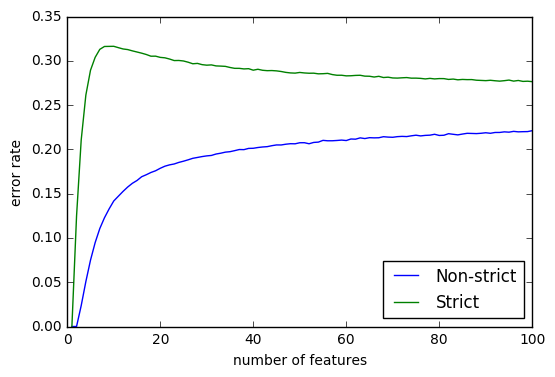

In [5]:
num_features = xrange(1, 100+1)
strict_error_rate = map(lambda n: compute_error_fraction(n, samples=1000000, strict_error=True), num_features)
non_strict_error_rate = map(lambda n: compute_error_fraction(n, samples=1000000, strict_error=False), num_features)
plt.plot(num_features, non_strict_error_rate, label='Non-strict')
plt.plot(num_features, strict_error_rate, label='Strict')
plt.xlabel('number of features')
plt.ylabel('error rate')
plt.legend(loc='lower right')

## Analyzing the difference between strict and non-strict cases

The only cases where there is a difference are those where one of the dot products is zero and the other isn't. The set of $h$ such that $h\cdot(x - y) = 0$ and $x \ne y$ has zero measure, then the only dot product that we expect could be zero is $u\cdot(x - y)$.

By the definition of $u$,

$u\cdot(x - y) = \frac{1}{n}\sum_i (x_i - y_i)$,

so the probability of a difference is equal to the probability of the sum of the components of $x - y$ being zero and $x \ne y$.

The sum of the components is a random variable distributed as the difference of two independent $B\left(n, \frac{1}{2}\right)$ random variables. The difference of $B\left(n, \frac{1}{2}\right)$ variables is a shifted binomial, as can be seen by noticing that $n - X \sim B\left(n, \frac{1}{2}\right)$ if $X \sim B\left(n, \frac{1}{2}\right)$, so $n + \sum_i (x_i - y_i) \sim B\left(2n, \frac{1}{2}\right)$.

If we want the probability of the sum of components being zero, it will be

$P\left(\sum_i (x_i - y_i) = 0\right) = \binom{2n}{n} \left(\frac{1}{2}\right)^{2n}$,

and subtracting the probability of both being equal we get

$P(\textrm{intermediate case}) = \frac{1}{2^{2n}}\binom{2n}{n} - \frac{1}{2^n}$.

Checking if it works:

In [6]:
cef_strict = compute_error_fraction(4, samples=1000000, strict_error=True)
cef_non_strict = compute_error_fraction(4, samples=1000000, strict_error=False)
print 'MC delta:', cef_strict - cef_non_strict
from math import factorial as fac
print 'Computed delta:', fac(2*4)/(fac(4)**2) * (1.0/(2 **(2*4))) - 1.0/(2**4)

MC delta: 0.211527
Computed delta: 0.2109375


Plotting it:

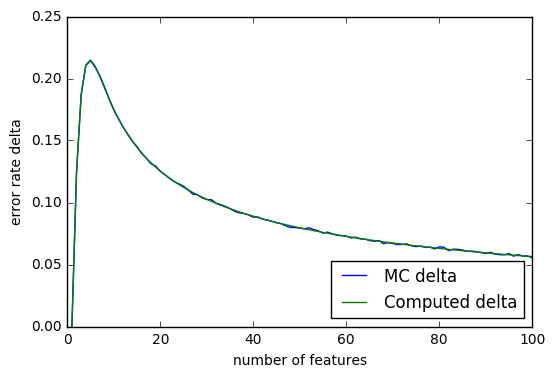

In [7]:
mc_delta = [ser - nser for ser, nser in zip(strict_error_rate, non_strict_error_rate)]
comp_delta = map(lambda n: fac(2*n)/(fac(n)**2) * (1.0/(2 **(2*n))) - 1.0/(2**n), num_features)
plt.plot(num_features, mc_delta, label='MC delta')
plt.plot(num_features,  comp_delta, label='Computed delta')
plt.xlabel('number of features')
plt.ylabel('error rate delta')
plt.legend(loc='lower right')

## Analyzing the $n = 2$ case

### Accurate simulation

Doing an accurate simulation for $n = 2$,

In [8]:
print 'Strict error fraction:', compute_error_fraction(2, samples=1000000, strict_error=True)
print 'Non-strict error fraction:', compute_error_fraction(2, samples=1000000, strict_error=False)

Strict error fraction: 0.124728
Non-strict error fraction: 0.0


we find the non-strict error fraction is exactly zero, while the strict one is around 12.5%.

### Non-strict error fraction

Our vector $h$ can be written as $\frac{1}{2}[1+\alpha\;1-\alpha]^T$, where $\alpha$ is a $\mathcal{U}(-1, 1)$ random variable. Let $d = x - y$, then the dot product inequality can be expressed as follows:

$(h \cdot d)(u \cdot d) < 0$

$\frac{1}{4}((d_1 + d_2) + \alpha (d_1 - d_2))(d_1 + d_2) < 0$

$(d_1 + d_2)^2 + \alpha (d_1^2 - d_2^2) < 0$

The first term is positive and WLOG we can assume $d_1^2 \le d_2^2$. Then the expression will take its minimum value for $\alpha = 1$. Substituting,

$d_1^2 + 2 d_1 d_2 + d_2^2 + d_1^2 - d_2^2 < 0$

$2 d_1^2 + 2 d_1 d_2 < 0$

we can see that the inequality will only be true iff either $d_1$ or $d_2$ is negative, $|d_1|$ is strictly smaller than $|d_2|$ and nonzero. For the case of our binomial vectors, $|d_i| \le 1$, so the conditions cannot be satisfied.

### Strict error fraction

The strict error fraction in this case can be computed as exactly

$\frac{1}{2^{2\cdot 2}}\binom{2\cdot 2}{2} - \frac{1}{2^2} = \frac{1}{16}\binom{4}{2} - \frac{1}{4} = \frac{6}{16} - \frac{1}{4} = \frac{1}{8}$.

## Analyzing the general case (non-strict)

We can only be in this case if one of the dot products is negative and the other positive.

### First case: $h \cdot d > 0$ and $u \cdot d < 0$

The components are subject to conditions

$\sum_i h_i d_i > 0$ and

$\sum_i d_i < 0$,

with the $h_i$ distributed uniformly in the [standard $n-1$ simplex](https://en.wikipedia.org/wiki/Simplex#The_standard_simplex) and the $d_i$ being a set of independent variables with $P(d_i = -1) = P(d_i = 1) = \frac{1}{4}$ and $P(d_i = 0) = \frac{1}{2}$.

### Second case: $h \cdot d < 0$ and $u \cdot d > 0$

In this case the components will have to follow

$\sum_i h_i d_i < 0$ and

$\sum_i d_i > 0$,

with the $h_i$ and $d_i$ distributed in the same way. 

We can see the situation is symmetric to the previous one and if we have calculated $P(h \cdot d < 0)$ for $d$ such that $u \cdot d > 0$, $d' = -d$ will satisfy $u \cdot d < 0$ and $P(h \cdot d' > 0) = P(h \cdot d < 0)$. So we only need to evaluate one of the cases.

### Varsi's algorithm

We can try to evaluate the value of $P(\sum_i h_i d_i < 0)$ for specific values of $d$. Each value of $d$ gives us a half-space and the normalized "area" of the intersection between the standard simplex and the half-space will give us the probability.

Using the notation of [Varsi's "The Multidimensional Content of the Frustum of the Simplex"](https://projecteuclid.org/download/pdf_1/euclid.pjm/1102946623), we have

$m_i = d_i$

$x_i = h_i$

and we want to compute $\rho'$.

By symmetry, we don't care about the order of the $m_i$, so we can sort them ensuring that

$m_1 = m_2 = \dots = m_{J'} = -1 < m_{J'+1} = m_{J'+2} = \dots = m_J = 0 < m_{J+1} = m_{J+2} = \dots = m_{n} = 1$,

and the algorithm can then be described in Python (translating to 0-based indices):

In [9]:
def varsi_alg(m):
    assert m == sorted(m)
    J = sum(1 if m_i <= 0.0 else 0 for m_i in m)
    n = len(m)
    alpha = [1.0] + [0.0] * (n - J)
    for h in xrange(J):
        for k in xrange(1, n - J + 1):
            alpha[k] = alpha[k - 1] * abs(m[J - h - 1]) / abs(m[J - h - 1] - m[n - k]) +\
                       alpha[k] * abs(m[n - k]) / abs(m[J - h - 1] - m[n - k])
    return alpha[-1]

We can test the algorithm by comparing with MC results:

In [10]:
def mc_varsi_ref(m, samples=10000):
    samples_in = 0
    for _ in xrange(samples):
        x = np.random.dirichlet(alpha=np.ones(len(m)))
        if np.dot(x, m) < 0.0:
            samples_in += 1
    return float(samples_in) / samples
m=[-1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 1.0, 1.0]
print 'varsi:', varsi_alg(m)
print 'MC:', mc_varsi_ref(m, samples=1000000)

varsi: 0.6875
MC: 0.686432


### Brute force

For small values of $n$ we can evaluate naively over all the possible values of $d$, taking care of the fact that their distribution is not uniform.

In [11]:
import itertools
def brute_force_ns_fraction(n):
    fraction = 0.0
    for m in itertools.product((-1.0, 0.0, 1.0), repeat=n):
        if sum(m) >= 0.0:
            continue
        num_zeros = m.count(0.0)
        weight = 0.5 ** num_zeros * 0.25 ** (n - num_zeros)
        fraction += weight * (1.0 - varsi_alg(sorted(m)))
    return 2.0 * fraction
print 'Error fraction (n = 5, brute force, Varsi):', brute_force_ns_fraction(5)
print 'Error fraction (n = 5, MC):', compute_error_fraction(5, samples=1000000, strict_error=False)
print 'Error fraction (n = 10, brute force, Varsi):', brute_force_ns_fraction(10)
print 'Error fraction (n = 10, MC):', compute_error_fraction(10, samples=1000000, strict_error=False)

Error fraction (n = 5, brute force, Varsi): 0.0750732421875
Error fraction (n = 5, MC): 0.074892
Error fraction (n = 10, brute force, Varsi): 0.140684694052
Error fraction (n = 10, MC): 0.140537


### Smarter brute force

The fact we are sorting $m$ shows we are being inefficient, computing the same results with Varsi's algorithm again and again. We can get a polynomial time algorithm by adding all those variants at the same time:

In [12]:
def smarter_bf_ns_fraction(n):
    fraction = 0.0
    for num_minus in range(n+1):
        for num_plus in range(min(num_minus, n - num_minus + 1)):
            num_zeros = n - num_minus - num_plus
            num_reps = fac(n) / (fac(num_zeros) * fac(num_plus) * fac(num_minus))
            mr = [-1] * num_minus + [0] * num_zeros + [1] * num_plus
            weight = 0.5 ** num_zeros * 0.25 ** (n - num_zeros) * num_reps
            fraction += weight * (1.0 - varsi_alg(mr))
    return 2.0 * fraction
print 'Error fraction (n = 10, smarter brute force, Varsi):', smarter_bf_ns_fraction(10)
print 'Error fraction (n = 10, MC):', compute_error_fraction(10, samples=1000000, strict_error=False)
print 'Error fraction (n = 50, smarter brute force, Varsi):', smarter_bf_ns_fraction(50)
print 'Error fraction (n = 50, MC):', compute_error_fraction(50, samples=1000000, strict_error=False)

Error fraction (n = 10, smarter brute force, Varsi): 0.140684694052
Error fraction (n = 10, MC): 0.140683
Error fraction (n = 50, smarter brute force, Varsi): 0.206885792899
Error fraction (n = 50, MC): 0.206105


### Fully evaluating Varsi's result

In our case the coefficients $m_i$ are specially simple, so we can try to see if we can find an analytical value for the output of Varsi's algorithm.

#### Numerical experiments

We can start by checking its values for small vectors:

In [13]:
for i in range(3):
    for j in range(3):
        for k in range(3):
            print i, j, k, varsi_alg([-1]*i + [0] * j + [1] * k)

0 0 0 1.0
0 0 1 0.0
0 0 2 0.0
0 1 0 1.0
0 1 1 0.0
0 1 2 0.0
0 2 0 1.0
0 2 1 0.0
0 2 2 0.0
1 0 0 1.0
1 0 1 0.5
1 0 2 0.25
1 1 0 1.0
1 1 1 0.5
1 1 2 0.25
1 2 0 1.0
1 2 1 0.5
1 2 2 0.25
2 0 0 1.0
2 0 1 0.75
2 0 2 0.5
2 1 0 1.0
2 1 1 0.75
2 1 2 0.5
2 2 0 1.0
2 2 1 0.75
2 2 2 0.5


We see the number of zeroes doesn't seem to affect the results, and the resulting numbers seem quite simple fractions. Testing only with 1 and -1 now and printing as fractions:

In [14]:
from fractions import Fraction
for i in range(5):
    for j in range(5):
        print i, j, Fraction(varsi_alg([-1]*i + [1]*j))

0 0 1
0 1 0
0 2 0
0 3 0
0 4 0
1 0 1
1 1 1/2
1 2 1/4
1 3 1/8
1 4 1/16
2 0 1
2 1 3/4
2 2 1/2
2 3 5/16
2 4 3/16
3 0 1
3 1 7/8
3 2 11/16
3 3 1/2
3 4 11/32
4 0 1
4 1 15/16
4 2 13/16
4 3 21/32
4 4 1/2


The fractions when having only one -1 component decrease by half with each step, but the others seem to be decreasing with a variable multiplier. If we print the quotients based of the number of -1 components:

In [15]:
for i in range(1,6):
    print 'Number of -1 components = %d, successive quotients are' % i,
    for j in range(10):
        print Fraction(varsi_alg([-1]*i + [1]*(j + 1))) / Fraction(varsi_alg([-1]*i + [1]*j)),
    print

Number of -1 components = 1, successive quotients are 1/2 1/2 1/2 1/2 1/2 1/2 1/2 1/2 1/2 1/2
Number of -1 components = 2, successive quotients are 3/4 2/3 5/8 3/5 7/12 4/7 9/16 5/9 11/20 6/11
Number of -1 components = 3, successive quotients are 7/8 11/14 8/11 11/16 29/44 37/58 23/37 14/23 67/112 79/134
Number of -1 components = 4, successive quotients are 15/16 13/15 21/26 16/21 93/128 65/93 44/65 29/44 299/464 189/299
Number of -1 components = 5, successive quotients are 31/32 57/62 33/38 163/198 128/163 193/256 281/386 397/562 1093/1588 1471/2186


When we have two -1 components, the numerators keep increasing by 1 and the denominators by 2, curiously the numerator and denominator of the series for one -1 component. Checking the pattern, it seems to hold for the third row if we use the shifted values of the upper series. That shows that maybe we should focus on values where the sum of $i$ and $j$ are constant:

In [16]:
for i in range(6+1):
    print Fraction(varsi_alg([-1]*i+[1]*(6-i))),
print

0 1/32 3/16 1/2 13/16 31/32 1


In [17]:
for i in range(6):
    print (varsi_alg([-1]*(i+1)+[1]*(6-i-1)) - varsi_alg([-1]*i+[1]*(6-i)))*32,
print

1.0 5.0 10.0 10.0 5.0 1.0


So the numerators seem to be just cumulative sums of binomial coefficients and the denominator seems to be $2^{i+j-1}$, where $i$ is the number of -1 components and $j$ the number of +1 components. Checking for $i+j = 20$:

In [18]:
def C(n, k):
    from math import factorial
    return factorial(n) / (factorial(n - k) * factorial(k))
print max(abs((varsi_alg([-1]*(i+1)+[1]*(20-i-1)) - varsi_alg([-1]*i+[1]*(20-i)))*(2**19) - C(19, i))
          for i in range(20))

0.0


So our conjecture will be that, if we call $K$ the number of -1 components of $d_i$ and $L$ the number of +1 components of $d_i$,

$\displaystyle P\left(\sum_i h_i d_i < 0\right) = \frac{\sum_{i=0}^{K-1}\binom{K+L-1}{i}}{2^{K+L-1}}$.

In [19]:
def varsi_pseudo_closed(K, L):
    return sum(C(K+L-1, i) for i in range(K)) / float(2**(K+L-1))
print varsi_pseudo_closed(17,13) - varsi_alg([-1]*17+[1]*13) 

0.0


#### Inductive proof

**[TO BE PROVED]**

### Looking for a more closed form

Putting all together,
   
$\displaystyle P_{error}(n) = \sum_{N_Z=0}^n \sum_{N_M=0}^{n-N_Z} \binom{n}{N_Z,N_M,n-(N_Z+N_M)}\frac{2^{N_Z}}{4^n}\frac{\sum_{i=0}^{N_M - 1}\binom{n - N_Z - 1}{i}}{2^{n - N_Z - 1}}$

we get a "closed form" expression for the probability. We can plot it to see how well it matches:


In [20]:
def p_error(n):
    from math import factorial
    ret = 0.0
    for n_z in range(n + 1):
        for n_m in range(n - n_z + 1):
            weight = float(factorial(n) / (factorial(n_z) * factorial(n_m) * factorial(n - n_z - n_m)))
            weight *= 2 ** n_z
            weight /= (4 ** n * 2 ** (n - n_z - 1))
            ret += weight * sum(C(n - n_z - 1, i) for i in range(n_m))
    return ret
p_error(50)

0.49999999999999956

**THERE IS SOME ERROR HERE**

**[TO BE COMPLETED]**